In [1]:
import matplotlib.image as image
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d


In [2]:
def manipulate_histogram(img):
    img = img.astype(float)
    # histo, bins = np.histogram(img.reshape(-1), bins=1000)
    im_std = img.std()*1.25
    im_min = img.mean()-1.5*im_std
    im_max = img.mean()+1.5*im_std
    img = np.minimum(255*(img-im_min)/(im_max-im_min),255)
    img = np.maximum(img,0)
    return img

In [3]:

def unsharp_masking(img):
    kernel = np.array([[1, 4, 6, 4, 1],[4, 16, 24, 16, 4],[6, 24, -476, 24, 6],[4, 16, 24, 16, 4],[1, 4, 6, 4, 1]])
    kernel = (-1/256)*kernel
    convolved = convolve2d(img, kernel, mode='valid', boundary="symm")
    convolved= np.minimum(255*(convolved-convolved.min())/(convolved.max()-convolved.min()),255)
    convolved = np.maximum(convolved,0)
    return convolved

In [4]:
def read_frame_dif_fase(folder, img_number):
    return image.imread(os.path.join('.', folder,str(img_number)+'-- fase_dif.bmp'))

def read_frame_fase(folder, img_number):
    return image.imread(os.path.join('.', folder,str(img_number)+'fase.bmp'))

In [5]:
f_folder = 'img_fase'
imgs = {}
for id in range(1,221):
    # reading every image
    imgs[id] = read_frame_fase(f_folder, id)
imgs_d = {}
for id in range(2,221):
    # reading every image
    imgs_d[id-1]= imgs[id]-imgs[id-1]

In [6]:
# we reduce the resolution, making square images
# we define the folder with the raw images

coso_set = []
coso_dif_set =[]

for id in range(1,220):
    # reading every image
    img_df = imgs_d[id]
    img_f = imgs[id]
    # increase contrast
    img_f = manipulate_histogram(img_f)
    img_df = manipulate_histogram(img_df)
    # apply filter
    img_f = unsharp_masking(img_f)
    img_df = unsharp_masking(img_df)
    # pick every 2 pixels in each direction
    img_f = img_f[::2,::2]
    img_df = img_df[::2,::2]
    # repeating the previous two steps
    img_f = unsharp_masking(img_f)
    img_df = unsharp_masking(img_df)
    img_f = img_f[::2,::2]
    img_df = img_df[::2,::2]
    # one bit transform
    # img = transform_one_bit(img)
    # testing the rescale
    img_f /= img_f.max()
    img_df /= img_df.max() 
    # cutting a piece to make a square image
    square_img_f = img_f[:,49:]
    square_img_df = img_df[:,49:]
    coso_set.append(square_img_f)
    coso_dif_set.append(square_img_df)


In [7]:
# saving the new square image
shuffled = np.arange(219)
np.random.shuffle(shuffled)

train_set_f = []
check_set_f = []
train_set_df = []
check_set_df = []
for i in range(len(shuffled)):
    id = shuffled[i]
    if i < 170:
        train_set_f.append(coso_set[id])
        train_set_df.append(coso_dif_set[id])
    else:
        check_set_f.append(coso_set[id])
        check_set_df.append(coso_dif_set[id])

In [8]:
print(np.array(check_set_df, dtype=np.float32).shape)

(49, 140, 140)


In [9]:
to_train_phase = torch.from_numpy(np.array(train_set_f, dtype=np.float32)).view(170,1,140,140)
to_train_difphase = torch.from_numpy(np.array(train_set_df, dtype=np.float32)).view(170,1,140,140)
to_check_phase = torch.from_numpy(np.array(check_set_f, dtype=np.float32)).view(49,1,140,140)
to_check_difphase = torch.from_numpy(np.array(check_set_df, dtype=np.float32)).view(49,1,140,140)

In [10]:
# Defining a model with a encoder (3 layers) and a decoder
class Reshape(torch.nn.Module):
    def __init__(self, *args) -> None:
        super().__init__()
        self.shape = args
    def forward(self, x):
        return x.view(self.shape)
class NewModel(torch.nn.Module):
    def __init__(self, n =140):
        super().__init__()
        # 3 convolutions, with equal-size kernels and same dimensions as the image
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1,
                            out_channels=8*2,
                            kernel_size=(3,3),
                            padding = (1,1),
                            stride = (1,1)),
            torch.nn.Dropout(0.25),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels = 8*2, 
                            out_channels= 16*2, 
                            kernel_size=(3,3), 
                            stride=(2,2), 
                            padding=(1,1)),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels = 16*2, 
                            out_channels= 32*2, 
                            kernel_size=(3,3), 
                            stride=(2,2), 
                            padding=(1,1)),
            torch.nn.Flatten(1)
                            )
        self.latent = torch.nn.Linear(2*32*35*35,50)
        self.relu = torch.nn.ReLU()
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(50, 2*32*140//4*140//4),
            Reshape(-1,32*2,35,35),
            torch.nn.ConvTranspose2d(in_channels = 32*2, 
                                out_channels=16*2, 
                                kernel_size=(3,3), 
                                stride=(2,2), 
                                padding=(1,1), output_padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(in_channels = 16*2, 
                                out_channels = 8*2, 
                                kernel_size=(3,3), 
                                stride=(2,2), 
                                padding=(1,1),
                                output_padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(in_channels = 8*2, 
                                out_channels = 1, 
                                kernel_size=(3,3), 
                                stride=(1,1), 
                                padding=(1,1)),
            torch.nn.Sigmoid()

        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.latent(x)
        x = self.relu(x)
        x = self.decoder(x)
        return x

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
# testing the model, before training
model_dif = NewModel().to(device)
input_test = torch.from_numpy(np.array(train_set_f[0], dtype=np.float32)).view(1,1,140,140).to(device)
print(input_test)
print(input_test.shape)
img_test = model_dif(input_test)
print(img_test.shape)
img_test.squeeze().detach().cpu().numpy()

tensor([[[[0.5371, 0.5155, 0.4936,  ..., 0.5313, 0.5314, 0.5325],
          [0.5570, 0.5355, 0.5297,  ..., 0.5517, 0.5553, 0.5572],
          [0.5519, 0.5374, 0.5450,  ..., 0.5593, 0.5634, 0.5631],
          ...,
          [0.5805, 0.5821, 0.5660,  ..., 0.5694, 0.5743, 0.5784],
          [0.5660, 0.5668, 0.5490,  ..., 0.5804, 0.5838, 0.5860],
          [0.5813, 0.5778, 0.5599,  ..., 0.6066, 0.6134, 0.6060]]]],
       device='cuda:0')
torch.Size([1, 1, 140, 140])
torch.Size([1, 1, 140, 140])


array([[0.42497966, 0.4054833 , 0.41108584, ..., 0.40635094, 0.4112299 ,
        0.40066004],
       [0.41305733, 0.41078857, 0.4001808 , ..., 0.40711936, 0.40414   ,
        0.40710038],
       [0.42193374, 0.40845376, 0.41007835, ..., 0.40157214, 0.4133621 ,
        0.40646034],
       ...,
       [0.41498232, 0.40612337, 0.40797448, ..., 0.4090325 , 0.40197033,
        0.41242644],
       [0.42156327, 0.40219972, 0.41312712, ..., 0.40486595, 0.40858454,
        0.40780994],
       [0.41380754, 0.4084329 , 0.4121743 , ..., 0.40880117, 0.40755102,
        0.42636627]], dtype=float32)

In [13]:
# Loss function and optimizator
criterion2 = torch.nn.MSELoss()
opt2 = torch.optim.Adam(model_dif.parameters(), lr = 0.0001)
hist2 = []
hist_tst = []

In [14]:
# training
for epochs in range(1000):
    model_dif.train()
    x = to_train_phase.to(device)
    y = to_train_difphase.to(device)
    prediction = model_dif(x)
    loss1 = criterion2(prediction, y)
    opt2.zero_grad()
    loss1.backward()
    opt2.step()
    hist2.append(loss1.item())
    if epochs%100 == 0:
        print(epochs, hist2[-1])
    
    with torch.no_grad():
        model_dif.eval()
        x = to_check_phase.to(device)
        y = to_check_difphase.to(device)
        prediction = model_dif(x)
        loss = criterion2(prediction, y)
        hist_tst.append(loss.item())

0 0.011884922161698341
100 0.01012976374477148
200 0.008743044920265675
300 0.008289691992104053
400 0.008036778308451176
500 0.007904981262981892
600 0.0077738892287015915
700 0.007647647988051176
800 0.007514163851737976
900 0.007368752267211676


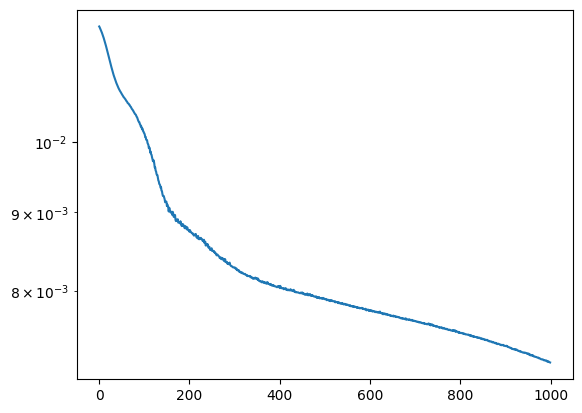

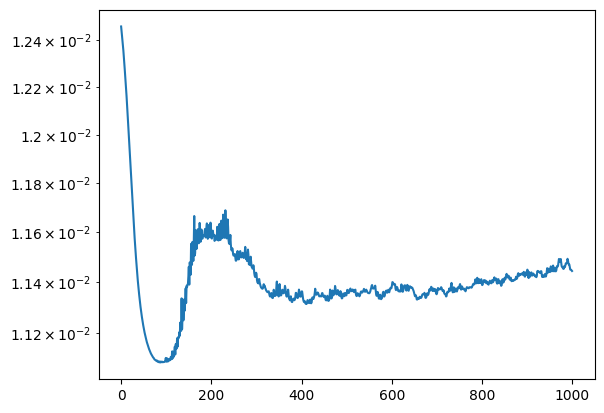

In [15]:
plt.semilogy(hist2)
plt.show()
plt.semilogy(hist_tst)

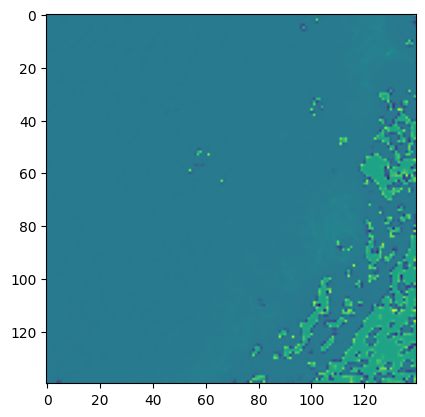

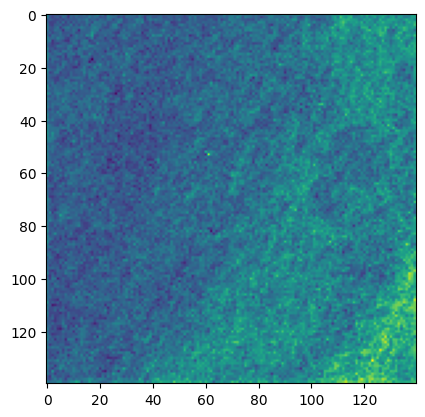

In [16]:
model_dif.eval()
x = to_check_phase.to(device)
y = to_check_difphase.to(device)
prediction = model_dif(x)
plt.imshow(y[0].detach().cpu().squeeze().numpy())
plt.show()
plt.imshow(prediction[0].detach().cpu().squeeze().numpy())